In [42]:
from __future__ import print_function
import time
import boto3
import json
from sagemaker import get_execution_role

REGION = 'us-west-2'
BUCKET = 'jashuang-sagemaker-5-22'
OUTPUT_PATH = f's3://{BUCKET}/a2i-results'

ROLE = get_execution_role()
display(ROLE)
# need to attach policies

'arn:aws:iam::688520471316:role/service-role/AmazonSageMaker-ExecutionRole-20200522T134110'

In [43]:
## ComprehendFullAccess 
## AmazonSageMakerFullAccess 
## AmazonS3FullAccess 
## AmazonAugmentedAIFullAccess

In [44]:
transcribe = boto3.client('transcribe', REGION)
s3 = boto3.client("s3", REGION)
job_name_1 = "AWS-sage-1"
# audio file path
job_uri_1 = "https://jashuang-sagemaker-5-22.s3-us-west-2.amazonaws.com/transcribe-bucket/Fully-Managed+Notebook+Instances+with+Amazon+SageMaker+-+a+Deep+Dive.mp4"
out_bucket = "jashuang-sagemaker-5-22"

In [5]:
# transcribe.start_transcription_job(
#     TranscriptionJobName=job_name,
#     Media={'MediaFileUri': job_uri},
#     MediaFormat='mp4',
#     LanguageCode='en-US'
# )

In [6]:
def transcribe(job_name, job_uri, out_bucket, format="mp4"):
    """Transcribe a .wav or .mp4 file to text.
    Args:
        job_name (str): the name of the job that you specify;
                        the output json will be job_name.json
        job_uri (str): input path (in s3) to the file being transcribed
        out_bucket (str): s3 bucket name that you want the output json
                          to be placed in
        format (str): mp4 or wav for input file format;
                      defaults to mp4
    """
    
    if format not in ['mp3','mp4','wav','flac']:
        print("Invalid format")
        return

    try:
        transcribe = boto3.client("transcribe")
        print("------" + format)
        transcribe.start_transcription_job(
            TranscriptionJobName=job_name,
            Media={"MediaFileUri": job_uri},
            MediaFormat=format,
            LanguageCode="en-US",
            OutputBucketName=out_bucket,
        )
        
        while True:
            status = transcribe.get_transcription_job(TranscriptionJobName=job_name)
            if status['TranscriptionJob']['TranscriptionJobStatus'] in ['COMPLETED', 'FAILED']:
                break
            print("Not ready yet...")
            time.sleep(5)
        print(status)

    except Exception as e:
        print(e)

In [75]:
def get_transcript_text_and_timestamps(bucket_name, file_name):
    """take json file from s3 bucket and returns a tuple of:
       entire transcript, list object of tuples of timestamp and individual sentences
    
    Args:
        bucket_name (str): name of s3 bucket
        file_name (str): name of file
    Returns:
        (entire_transcript: str,
        [ {timestamp (in seconds) : int, sentence : str} ])
    """
    s3_clientobj = s3.get_object(Bucket=bucket_name, Key=file_name)
    s3_clientdata = s3_clientobj["Body"].read().decode("utf-8")

    original = json.loads(s3_clientdata)
    items = original["results"]["items"]
    entire_transcript = original["results"]["transcripts"]

    sentences_and_times = []
    temp_sentence = ""
    temp_start_time = 0
    temp_min_confidence = 1.0
    newSentence = True
    
    confidences = []
    scores = []

    i = 0
    for item in items:
        # always add the word
        if item["type"] == "punctuation":
            temp_sentence = (
                temp_sentence.strip() + item["alternatives"][0]["content"] + " "
            )
        else:
            temp_sentence = temp_sentence + item["alternatives"][0]["content"] + " "
            temp_min_confidence = min(temp_min_confidence,
                                      float(item["alternatives"][0]["confidence"]))
            confidences.append({"start_time": float(item["start_time"]),
                                "end_time": float(item["end_time"]),
                                "content": item["alternatives"][0]["content"],
                                "confidence": float(item["alternatives"][0]["confidence"])
                               })
            scores.append(float(item["alternatives"][0]["confidence"]))

        # if this is a new sentence, and it starts with a word, save the time
        if newSentence == True:
            if item["type"] == "pronunciation":
                temp_start_time = float(item["start_time"])
            newSentence = False
        # else, keep going until you hit a punctuation
        else:
            if (
                item["type"] == "punctuation"
                and item["alternatives"][0]["content"] != ","
            ):
                # end time of sentence is end_time of previous word
                end_time = items[i-1]["end_time"] if i-1 >= 0 else items[0]["end_time"]
                sentences_and_times.append(
                    {"start_time": temp_start_time,
                     "end_time": end_time,
                     "sentence": temp_sentence.strip(),
                     "min_confidence": temp_min_confidence
                    }
                )
                # reset the temp sentence and relevant variables
                newSentence = True
                temp_sentence = ""
                temp_min_confidence = 1.0
                
        i = i + 1

    return entire_transcript, sentences_and_times, confidences, scores

In [54]:
# transcribe(job_name_1, job_uri_1, out_bucket)

In [76]:
entire_transcript_1, sentences_and_times_1, confidences_1, scores = get_transcript_text_and_timestamps("jashuang-sagemaker-5-22","AWS-sage-1.json")

In [12]:
# entire_transcript_1

In [19]:
# print(scores)

In [ ]:
for conf

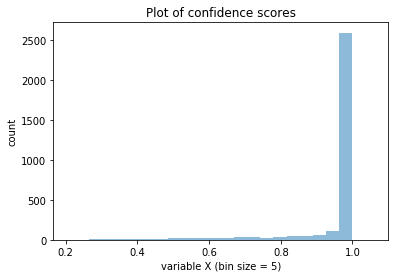

In [47]:
from matplotlib import pyplot as plt

plt.xlim([min(scores)-0.1, max(scores)+0.1])
plt.hist(scores, bins=20, alpha=0.5)
plt.title('Plot of confidence scores')
plt.xlabel('variable X (bin size = 5)')
plt.ylabel('count')

plt.show()

In [41]:
import numpy as np
print(len(scores))

3174


In [35]:
bad_scores = [i for i in scores if i < 0.9]

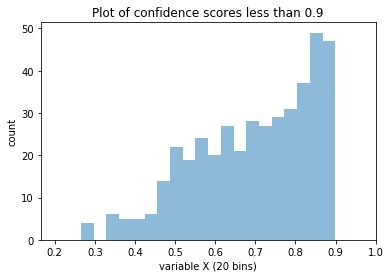

In [39]:
plt.xlim([min(bad_scores)-0.1, 1.0])
plt.hist(bad_scores, bins=20, alpha=0.5)
plt.title('Plot of confidence scores less than 0.9')
plt.xlabel('variable X (20 bins)')
plt.ylabel('count')

plt.show()

In [40]:
len(bad_scores)

421

In [78]:
# for tup in sentences_and_times_1:
#     print(str(tup['start_time']) + " -- "  +
#           str(tup['end_time']) + " -- "+
#           tup['sentence']+ " -- "+
#           str(tup['min_confidence'])
#          )

In [ ]:
WORKTEAM_ARN= "arn:aws:sagemaker:us-west-2:688520471316:workteam/private-crowd/jashuang-test-workforce"

In [50]:
import io
import json
import uuid
import time
import boto3
import botocore

# Amazon SageMaker client
sagemaker = boto3.client('sagemaker', REGION)

# Amazon Comprehend client
comprehend = boto3.client('comprehend', REGION)

# Amazon Augment AI (A2I) client
a2i = boto3.client('sagemaker-a2i-runtime')

s3 = boto3.client('s3', REGION)

In [51]:
template = r"""
something something something
"""

def create_task_ui():
    '''
    Creates a Human Task UI resource.

    Returns:
    struct: HumanTaskUiArn
    '''
    response = sagemaker.create_human_task_ui(
        HumanTaskUiName=taskUIName,
        UiTemplate={'Content': template})
    return response

In [52]:
# Task UI name - this value is unique per account and region. You can also provide your own value here.
taskUIName = 'ui-transcribe-' + str(uuid.uuid4()) 

# Create task UI
humanTaskUiResponse = create_task_ui()
humanTaskUiArn = humanTaskUiResponse['HumanTaskUiArn']
print(humanTaskUiArn)

arn:aws:sagemaker:us-west-2:688520471316:human-task-ui/ui-transcribe-5f6c3d75-b71d-400e-8d67-c61c444b4b75


In [ ]:
# Flow definition name - this value is unique per account and region. You can also provide your own value here.
flowDefinitionName = 'fd-transcribe-demo-' + str(uuid.uuid4()) 

create_workflow_definition_response = sagemaker.create_flow_definition(
        FlowDefinitionName= flowDefinitionName,
        RoleArn= ROLE,
        HumanLoopConfig= {
            "WorkteamArn": WORKTEAM_ARN,
            "HumanTaskUiArn": humanTaskUiArn,
            "TaskCount": 1,
            "TaskDescription": "Identify the word spoken the provided audio clip",
            "TaskTitle": "Determine Word of Audio Clip"
        },
        OutputConfig={
            "S3OutputPath" : OUTPUT_PATH
        }
    )
flowDefinitionArn = create_workflow_definition_response['FlowDefinitionArn'] # let's save this ARN for future use

In [ ]:
# Describe flow definition - status should be active
for x in range(60):
    describeFlowDefinitionResponse = sagemaker.describe_flow_definition(FlowDefinitionName=flowDefinitionName)
    print(describeFlowDefinitionResponse['FlowDefinitionStatus'])
    if (describeFlowDefinitionResponse['FlowDefinitionStatus'] == 'Active'):
        print("Flow Definition is active")
        break
    time.sleep(2)

In [82]:
print(confidences_1[0:1])

[{'start_time': 0.54, 'end_time': 1.03, 'content': 'Hi', 'confidence': 1.0}]


In [88]:
# use this to get the words near a word with poor confidence,
# since it is possible that the transcription also mis-transcribed nearby words/phrases
def get_word_neighbors(words, index):
    i = max(0, index - 3)
    j = min(len(words), index + 3)
    return words[i: j + 1], words[i]["start_time"], words[j]["end_time"]

In [93]:
words_list, start, end = get_word_neighbors(confidences_1, 2)
print(words_list)
print(len(words_list))
print(start)
print(end)

[{'start_time': 0.54, 'end_time': 1.03, 'content': 'Hi', 'confidence': 1.0}, {'start_time': 1.36, 'end_time': 1.5, 'content': 'My', 'confidence': 1.0}, {'start_time': 1.5, 'end_time': 1.7, 'content': 'name', 'confidence': 1.0}, {'start_time': 1.7, 'end_time': 1.85, 'content': 'is', 'confidence': 1.0}, {'start_time': 1.85, 'end_time': 2.1, 'content': 'Emily', 'confidence': 0.9886}, {'start_time': 2.1, 'end_time': 2.51, 'content': 'Weber', 'confidence': 0.7289}]
6
0.54
2.51


In [62]:
bad_conf_words = []
i=0
for obj in confidences_1:
    if obj['confidence'] < 0.4:
        bad_conf_words.append(obj)
    i=i+1

In [68]:
print(bad_conf_words[2])

{'start_time': 91.02, 'end_time': 91.36, 'content': 'Annecy', 'confidence': 0.3542}


In [ ]:
# Sample data, human loop started
human_loops_started = []
CONFIDENCE_SCORE_THRESHOLD = .99
for obj in confidences_1:
    # Call AWS Comprehend's Detect Sentiment API
    response = comprehend.detect_sentiment(Text=blurb, LanguageCode='en')
    sentiment = response['Sentiment']
    
    print(f'Processing word: \"{obj["content"]}\"')
    
    # Our condition for when we want to engage a human for review
    if (obj["confidence"] < CONFIDENCE_SCORE_THRESHOLD):
    
        humanLoopName = str(uuid.uuid4())
        inputContent = {
            "initialValue": sentiment.title(),
            "taskObject": blurb
        }
        start_loop_response = a2i.start_human_loop(
            HumanLoopName=humanLoopName,
            FlowDefinitionArn=flowDefinitionArn,
            HumanLoopInput={
                "InputContent": json.dumps(inputContent)
            }
        )
        human_loops_started.append(humanLoopName)
        print(f'SentimentScore of {response["SentimentScore"][capsToCamel(sentiment)]} is less than the threshold of {SENTIMENT_SCORE_THRESHOLD}')
        print(f'Starting human loop with name: {humanLoopName}  \n')
    else:
        print(f'SentimentScore of {response["SentimentScore"][capsToCamel(sentiment)]} is above threshold of {SENTIMENT_SCORE_THRESHOLD}')
        print('No human loop created. \n')

In [ ]:
# Check Status of Human Loop

completed_human_loops = []
for human_loop_name in human_loops_started:
    resp = a2i.describe_human_loop(HumanLoopName=human_loop_name)
    print(f'HumanLoop Name: {human_loop_name}')
    print(f'HumanLoop Status: {resp["HumanLoopStatus"]}')
    print(f'HumanLoop Output Destination: {resp["HumanLoopOutput"]}')
    print('\n')
    
    if resp["HumanLoopStatus"] == "Completed":
        completed_human_loops.append(resp)



In [83]:
# Wait For Workers to Complete Task
workteamName = WORKTEAM_ARN[WORKTEAM_ARN.rfind('/') + 1:]
print("Navigate to the private worker portal and do the tasks. Make sure you've invited yourself to your workteam!")
print('https://' + sagemaker.describe_workteam(WorkteamName=workteamName)['Workteam']['SubDomain'])

NameError: name 'WORKTEAM_ARN' is not defined

In [ ]:
# Check Status of Human Loop Again

completed_human_loops = []
for human_loop_name in human_loops_started:
    resp = a2i.describe_human_loop(HumanLoopName=human_loop_name)
    print(f'HumanLoop Name: {human_loop_name}')
    print(f'HumanLoop Status: {resp["HumanLoopStatus"]}')
    print(f'HumanLoop Output Destination: {resp["HumanLoopOutput"]}')
    print('\n')
    
    if resp["HumanLoopStatus"] == "Completed":
        completed_human_loops.append(resp)



In [ ]:

# View Task Results¶

# Once work is completed, Amazon A2I stores results in your S3 bucket and sends a Cloudwatch event. Your results should be available in the S3 OUTPUT_PATH when all work is completed.

import re
import pprint

pp = pprint.PrettyPrinter(indent=4)

for resp in completed_human_loops:
    splitted_string = re.split('s3://' +  BUCKET + '/', resp['HumanLoopOutput']['OutputS3Uri'])
    output_bucket_key = splitted_string[1]

    response = s3.get_object(Bucket=BUCKET, Key=output_bucket_key)
    content = response["Body"].read()
    json_output = json.loads(content)
    pp.pprint(json_output)
    print('\n')

